# Flex Net: A Configurable Neural Network for Sound Parsing

### Avant Garde Composer

Code to generate batches of random marimba compositions (with piano roll and corresponding audio)

In [1]:
import tensorflow as tf
from sonic import *

class Generate_Batch():
    def __init__(self, batch_size, length_in_beats, sample_rate, bpm):
        self.song = Song(SampleBank(), length_in_beats, bpm, sample_rate)
        self.batch_size = batch_size
        self.num_inst_samples = self.song.num_inst_samples
        self.length_in_beats = length_in_beats
        self.bpm = bpm
        self.sr = sample_rate
        self.N = self.sr * self.length_in_beats * 60 // self.bpm
        self.samples_per_beat = (self.sr * 60) // self.bpm
        self.batch_audio = tf.Variable(tf.zeros([self.batch_size, self.length_in_beats-4, self.samples_per_beat*5], dtype=tf.float32))
        self.batch_piano_roll = tf.Variable(tf.zeros([self.batch_size, self.length_in_beats-4, self.num_inst_samples], dtype=tf.float32))
    
    #@tf.function
    def __chop__(self, song_output, song_notes_float):
        audio = tf.TensorArray(tf.float32, size=(self.length_in_beats-4), element_shape=(self.samples_per_beat*5,))
        piano_roll = tf.TensorArray(tf.float32, size=(self.length_in_beats-4), element_shape=(self.num_inst_samples,))
        for j in tf.range(self.song.length_in_beats - 4):
            audio.write(j, song_output[j*self.samples_per_beat:(j+5)*self.samples_per_beat])
            piano_roll.write(j, tf.reshape(song_notes_float, [self.song.length_in_beats, self.song.num_inst_samples])[j])
        return audio.stack(), piano_roll.stack()
    
    #@tf.function
    def __call__(self):
        for i in range(self.batch_size):
            self.song.zero()
            for j in range(np.random.choice([3,4,5,6,7,8,9,10,11,12])):
                self.song.generate()
            self.song.compile()
            audio, piano_roll = self.__chop__(self.song.output, self.song.notes_float)
            self.batch_audio[i].assign(audio)
            self.batch_piano_roll[i].assign(piano_roll)
        return self.batch_audio, self.batch_piano_roll    

In [2]:
batch_size = 10
batches_per_epoch = 10

generate_batch = Generate_Batch(batch_size, 4*10, 44100, 60*10)

Marimba_cord_ff  --- notes  36  through  96


In [3]:
# Example of a random composition

from IPython.display import Audio

generate_batch.song.generate()
example_composition = generate_batch.song.output.numpy()

Audio(example_composition, rate=44100, autoplay=True)

## Neural Network Classes

In [5]:
from neural2 import *

class Network(tf.Module):
    def __init__(self, name=None):
        super(Network, self).__init__(name=name)
        self.layers = []
        
                
        sample_rate = 44100                 # 44.1khz sample rate
        frame_length = sample_rate // 10    # frame size of 0.1 seconds
        num_frames = 5                      # five frames read at a time
        input_features = int(frame_length * num_frames)
    
        self.layers.append(DisperseLayer(input_features, frame_length, 1.0))
        num_chunks = num_frames
        
        self.layers.append(RFFTLayer(self.layers[-1].chunk_size))
        
        self.layers.append(ReluLayer(self.layers[-1].output_features, self.layers[-1].output_features // 16))
        self.layers.append(ReluLayer(self.layers[-1].output_features, self.layers[-1].output_features // 2))
        self.layers.append(ReluLayer(self.layers[-1].output_features, self.layers[-1].output_features // 2))
    
        
        self.layers.append(JoinLayer(self.layers[-1].output_features, num_chunks))
        
        self.layers.append(ReluLayer(self.layers[-1].output_features, self.layers[-1].output_features))
        self.layers.append(ReluLayer(self.layers[-1].output_features, self.layers[-1].output_features // 4))
        self.layers.append(SigmoidLayer(self.layers[-1].output_features, 61))
        

    def save(self, path):
        if not os.path.exists(path):
            os.makedirs(path)
        for i, layer in enumerate(self.layers):
            if not os.path.exists(os.path.join(path, f'layer_{i}')):
                os.makedirs(os.path.join(path, f'layer_{i}'))
            layer.save(os.path.join(path, f'layer_{i}'))
            
    def load(self, path):
        for i, layer in enumerate(self.layers):
            layer.load(os.path.join(path, f'layer_{i}'))
        
    def apply(self, data, layers):
        if len(layers) == 1:
            return layers[0](data)
        else:
            return self.apply(layers[0](data), layers[1:])

    #@tf.function
    def __call__(self, data):
        x = data
        for i, layer in enumerate(self.layers):
            x = layer(x)
        return x
        #return self.apply(data, self.layers)
        
    def reset(self):
        for layer in self.layers:
            layer.reset()

network = Network()

Disperse Layer. Input Features: 22050 Chunk Size: 4410 Num Chunks: 5
RFFT Layer. Input Features: 4410 Output Features: 8194
RELU Layer. Input Features: 8194 Output Features: 512
RELU Layer. Input Features: 512 Output Features: 256
RELU Layer. Input Features: 256 Output Features: 128
Join Layer. Input Chunk Size: 128 Num Input Chunks: 5 Output Features: 640
RELU Layer. Input Features: 640 Output Features: 640
RELU Layer. Input Features: 640 Output Features: 160
Sigmoid Layer. Input Features: 160 Output Features: 61


In [6]:
def clean_output(arr):
    N = arr.shape[0]
    M = arr.shape[1]
    output = np.zeros([N, M])
    for i in range(N):
        for j in range(M):
            output[i][j] = int(max(0, min(127, round(128 * arr[i][j]))))
    return output

In [7]:
network.reset()

Epoch 3209 completed!
Step 32099 complete.
Cost: 0.476840973 Note Cost: 0.133776724 Regularization Cost: 3430.64258
Global Norm: 0.11891686


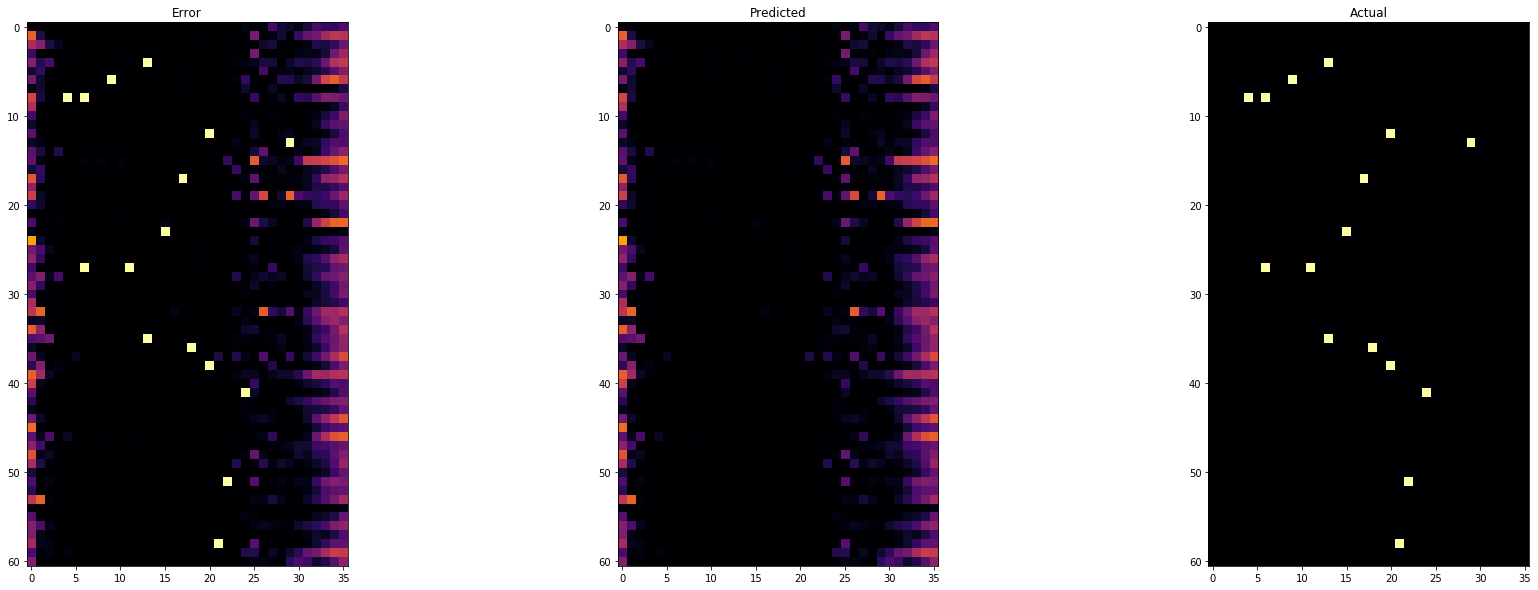

Step 32100 complete.
Cost: 0.453076661 Note Cost: 0.11001242 Regularization Cost: 3430.64258
Global Norm: 0.15274265
Step 32101 complete.
Cost: 0.465413 Note Cost: 0.122348763 Regularization Cost: 3430.64258
Global Norm: 0.115771554
Step 32102 complete.
Cost: 0.462568283 Note Cost: 0.119504035 Regularization Cost: 3430.64258
Global Norm: 0.121666074
Step 32103 complete.
Cost: 0.444739521 Note Cost: 0.101675265 Regularization Cost: 3430.64258
Global Norm: 0.13785905
Step 32104 complete.
Cost: 0.448731482 Note Cost: 0.105667219 Regularization Cost: 3430.64258
Global Norm: 0.11382853
Step 32105 complete.
Cost: 0.468492389 Note Cost: 0.12542814 Regularization Cost: 3430.64258
Global Norm: 0.12805082
Step 32106 complete.
Cost: 0.471915096 Note Cost: 0.128850847 Regularization Cost: 3430.64258
Global Norm: 0.1385136
Step 32107 complete.
Cost: 0.449612558 Note Cost: 0.106548294 Regularization Cost: 3430.64258
Global Norm: 0.12475801
Step 32108 complete.
Cost: 0.449702561 Note Cost: 0.10663831

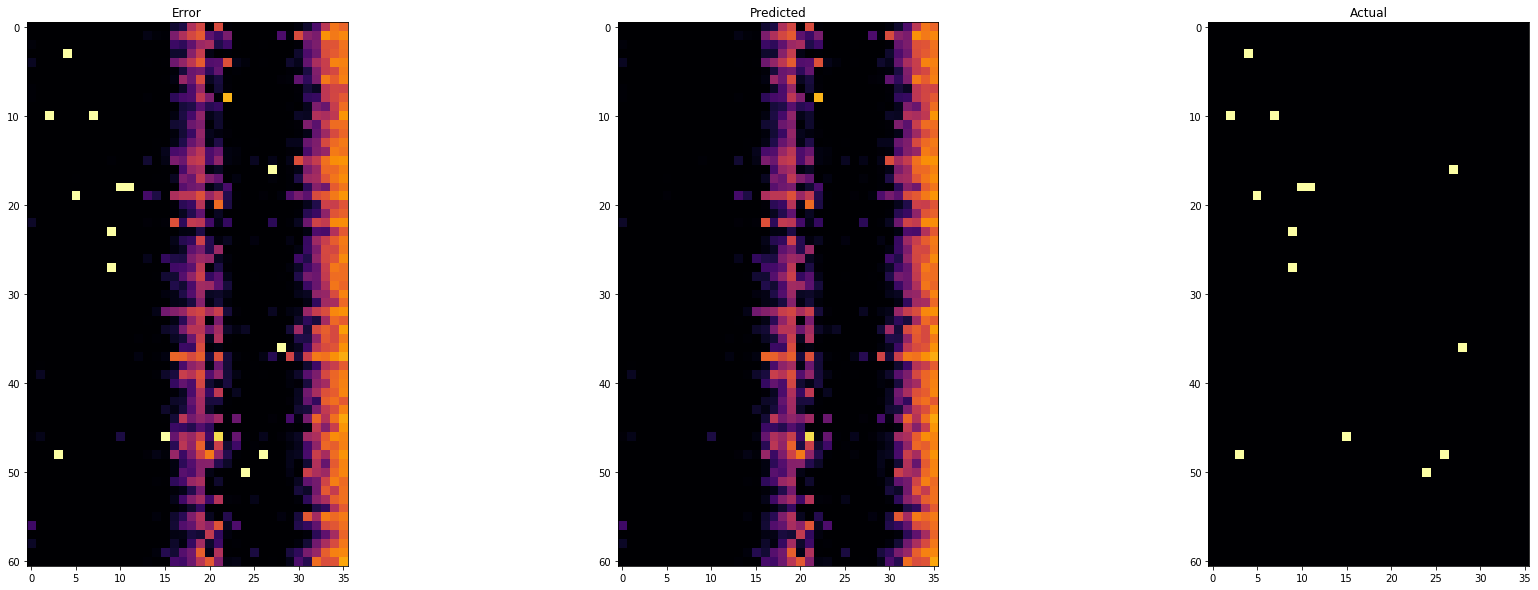

Step 32110 complete.
Cost: 0.45743522 Note Cost: 0.114371069 Regularization Cost: 3430.6416
Global Norm: 0.14960489
Step 32111 complete.
Cost: 0.447789371 Note Cost: 0.104725197 Regularization Cost: 3430.6416
Global Norm: 0.12144442
Step 32112 complete.
Cost: 0.442543894 Note Cost: 0.0994797423 Regularization Cost: 3430.6416
Global Norm: 0.13855359
Step 32113 complete.
Cost: 0.445925534 Note Cost: 0.10286139 Regularization Cost: 3430.6416
Global Norm: 0.133699
Step 32114 complete.
Cost: 0.448894083 Note Cost: 0.105829939 Regularization Cost: 3430.6416
Global Norm: 0.14085895
Step 32115 complete.
Cost: 0.444664598 Note Cost: 0.101600453 Regularization Cost: 3430.6416
Global Norm: 0.13532357
Step 32116 complete.
Cost: 0.449844837 Note Cost: 0.106780663 Regularization Cost: 3430.6416
Global Norm: 0.114402846
Step 32117 complete.
Cost: 0.461698592 Note Cost: 0.118634447 Regularization Cost: 3430.6416
Global Norm: 0.12118376
Step 32118 complete.
Cost: 0.46546337 Note Cost: 0.122399211 Regul

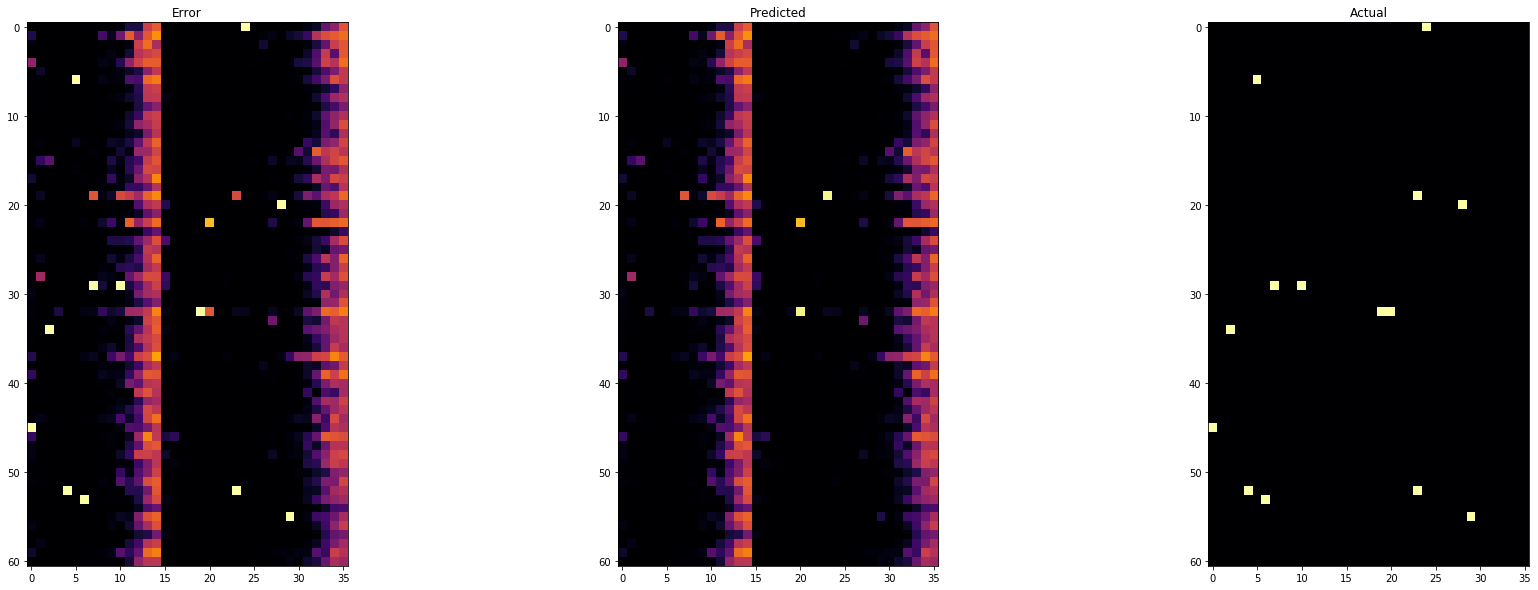

Step 32120 complete.
Cost: 0.468509942 Note Cost: 0.125445902 Regularization Cost: 3430.64062
Global Norm: 0.1253756
Step 32121 complete.
Cost: 0.451484472 Note Cost: 0.108420432 Regularization Cost: 3430.64062
Global Norm: 0.14714085
Step 32122 complete.
Cost: 0.436515272 Note Cost: 0.0934512466 Regularization Cost: 3430.64062
Global Norm: 0.13437945
Step 32123 complete.
Cost: 0.432401031 Note Cost: 0.0893369839 Regularization Cost: 3430.64062
Global Norm: 0.13326378
Step 32124 complete.
Cost: 0.457021326 Note Cost: 0.113957286 Regularization Cost: 3430.64062
Global Norm: 0.13263273
Step 32125 complete.
Cost: 0.468291223 Note Cost: 0.125227168 Regularization Cost: 3430.64062
Global Norm: 0.1088233
Step 32126 complete.
Cost: 0.459564805 Note Cost: 0.11650078 Regularization Cost: 3430.64062
Global Norm: 0.1348246
Step 32127 complete.
Cost: 0.463296354 Note Cost: 0.120232306 Regularization Cost: 3430.64062
Global Norm: 0.11752784
Step 32128 complete.
Cost: 0.482547343 Note Cost: 0.139483

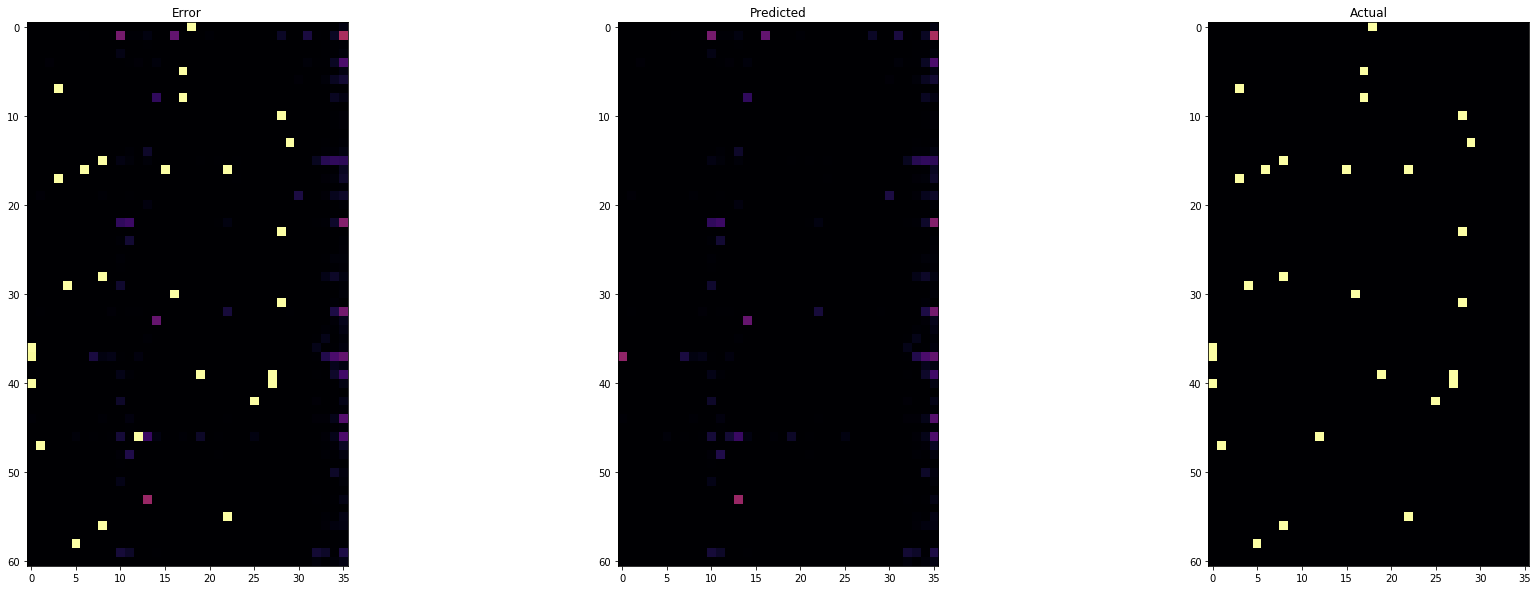

Step 32130 complete.
Cost: 0.454719067 Note Cost: 0.111655138 Regularization Cost: 3430.63916
Global Norm: 0.12555493
Step 32131 complete.
Cost: 0.46166423 Note Cost: 0.118600301 Regularization Cost: 3430.63916
Global Norm: 0.11699491
Step 32132 complete.
Cost: 0.450615227 Note Cost: 0.107551306 Regularization Cost: 3430.63916
Global Norm: 0.14257193
Step 32133 complete.
Cost: 0.468969017 Note Cost: 0.125905097 Regularization Cost: 3430.63916
Global Norm: 0.15404883
Step 32134 complete.
Cost: 0.429281801 Note Cost: 0.0862178802 Regularization Cost: 3430.63916
Global Norm: 0.12601492
Step 32135 complete.
Cost: 0.449454188 Note Cost: 0.106390283 Regularization Cost: 3430.63916
Global Norm: 0.12094593
Step 32136 complete.
Cost: 0.461018622 Note Cost: 0.117954701 Regularization Cost: 3430.63916
Global Norm: 0.10995443
Step 32137 complete.
Cost: 0.476230741 Note Cost: 0.133166805 Regularization Cost: 3430.63916
Global Norm: 0.1435676
Step 32138 complete.
Cost: 0.451073766 Note Cost: 0.10800

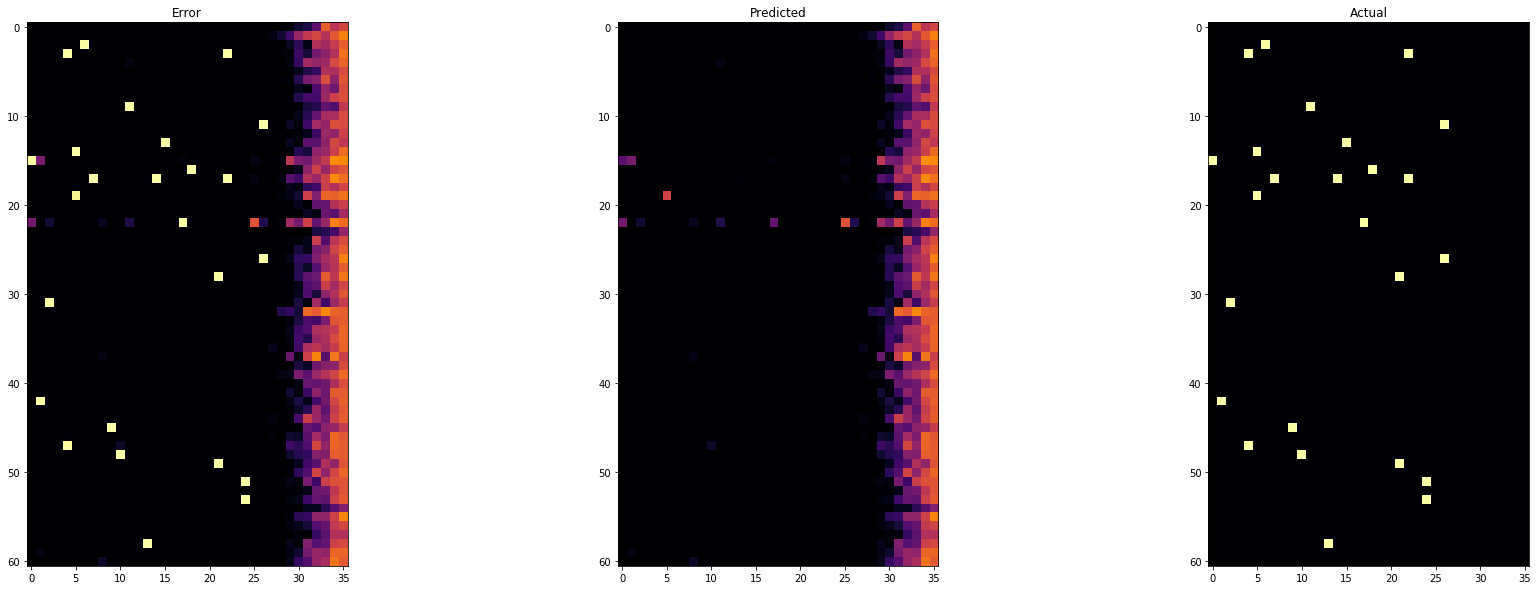

Step 32140 complete.
Cost: 0.473621488 Note Cost: 0.130557716 Regularization Cost: 3430.6377
Global Norm: 0.12746397
Step 32141 complete.
Cost: 0.459315747 Note Cost: 0.116251975 Regularization Cost: 3430.6377
Global Norm: 0.13100757
Step 32142 complete.
Cost: 0.457284 Note Cost: 0.114220232 Regularization Cost: 3430.6377
Global Norm: 0.12851071
Step 32143 complete.
Cost: 0.466093361 Note Cost: 0.123029597 Regularization Cost: 3430.6377
Global Norm: 0.13447785
Step 32144 complete.
Cost: 0.447088122 Note Cost: 0.104024366 Regularization Cost: 3430.6377
Global Norm: 0.1332584
Step 32145 complete.
Cost: 0.442673743 Note Cost: 0.0996099859 Regularization Cost: 3430.6377
Global Norm: 0.12506123
Step 32146 complete.
Cost: 0.468560189 Note Cost: 0.125496417 Regularization Cost: 3430.6377
Global Norm: 0.123946466
Step 32147 complete.
Cost: 0.466118813 Note Cost: 0.123055026 Regularization Cost: 3430.6377
Global Norm: 0.14163785
Step 32148 complete.
Cost: 0.456804872 Note Cost: 0.113741115 Regu

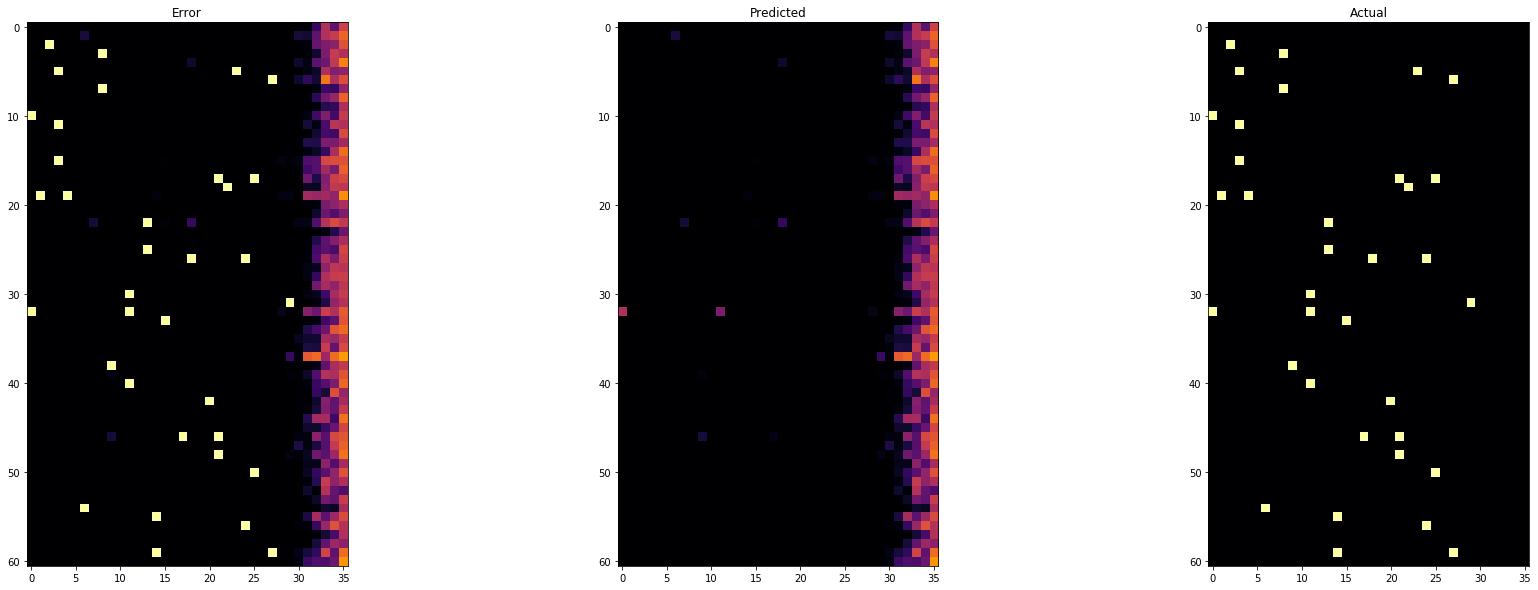

Step 32150 complete.
Cost: 0.45142597 Note Cost: 0.108362325 Regularization Cost: 3430.63672
Global Norm: 0.12971728
Step 32151 complete.
Cost: 0.463855863 Note Cost: 0.120792218 Regularization Cost: 3430.63672
Global Norm: 0.15412934
Step 32152 complete.
Cost: 0.440954775 Note Cost: 0.0978911296 Regularization Cost: 3430.63672
Global Norm: 0.16060749
Step 32153 complete.
Cost: 0.453657836 Note Cost: 0.110594191 Regularization Cost: 3430.63672
Global Norm: 0.14369358
Step 32154 complete.
Cost: 0.475712299 Note Cost: 0.132648662 Regularization Cost: 3430.63672
Global Norm: 0.15005782
Step 32155 complete.
Cost: 0.433892041 Note Cost: 0.0908283815 Regularization Cost: 3430.63672
Global Norm: 0.13003956
Step 32156 complete.
Cost: 0.458709717 Note Cost: 0.115646079 Regularization Cost: 3430.63672
Global Norm: 0.14557883
Step 32157 complete.
Cost: 0.467011571 Note Cost: 0.123947926 Regularization Cost: 3430.63672
Global Norm: 0.13124283
Step 32158 complete.
Cost: 0.438870788 Note Cost: 0.095

In [ ]:
from IPython.display import display, clear_output, Audio
import seaborn as sns
import sys, signal
import matplotlib.pyplot as plt
import plotting

keep_going = True
def signal_handler(signal, frame):
    global keep_going
    keep_going = False
signal.signal(signal.SIGINT, signal_handler)

#@tf.function
def loss(trainable_variables, notes_actual, notes_predicted):
    note_cost = tf.reduce_mean(-notes_actual * tf.math.log(0.0001 + notes_predicted) - (1 - notes_actual) * tf.math.log(1.0001 - notes_predicted))
    regularization_cost = 0.0
    for i in range(len(trainable_variables)):
        regularization_cost +=  tf.reduce_sum(trainable_variables[i] ** 2)
    cost = note_cost + (1/10000) * regularization_cost
    tf.print('Cost:', cost, 'Note Cost:', note_cost, 'Regularization Cost:', regularization_cost)
    return cost
    

@tf.function
def grad(network, input_pcms, notes_actual):
    with tf.GradientTape() as tape:
        tape.watch(network.trainable_variables)
        notes_predicted = network(input_pcms)
        loss_value = loss(network.trainable_variables, notes_actual, notes_predicted)
    return loss_value, notes_predicted, tf.clip_by_global_norm(tape.gradient(loss_value, network.trainable_variables), 1000000.0)

#@tf.function
def apply_grads(trainable_vars, grads, learning_rate):
    for i in range(len(grads)):
        trainable_vars[i].assign_sub(learning_rate * grads[i])

#optimizer = tf.keras.optimizers.SGD(learning_rate=0.001, momentum=0.001) #, momentum=0.01) #, momentum=0.1, nesterov=True)
optimizer=tf.keras.optimizers.SGD(learning_rate=0.001)


num_inst_samples = 61
length_in_seconds = 4
quantization = 10
length_in_beats = length_in_seconds * quantization


learning_rate = 0.001

grads = tuple(tf.Variable(tf.zeros_like(var, dtype=tf.float32)) for var in network.trainable_variables)

i = -1
while keep_going:
    i += 1
    input_pcms, notes_actual = generate_batch()

    loss_value, notes_predicted, (new_grads, global_norm) = grad(network, input_pcms, notes_actual)
    print('Global Norm:', global_norm.numpy())
    for j in range(len(grads)):
        grads[j].assign_add(tf.where(tf.math.is_nan(new_grads[j]), tf.zeros_like(new_grads[j]), new_grads[j]) / batches_per_epoch)

    if i % 100 == 99:
        clear_output()
        
    if i % 10 == 0:
        pass
        fig = plotting.error(notes_predicted, notes_actual)
        display(fig)
        plt.close(fig)
        del fig

    
    if (i % batches_per_epoch) == (batches_per_epoch - 1):
        apply_grads(network.trainable_variables, grads, learning_rate)
        #optimizer.apply_gradients(zip(grads, network.trainable_variables))
    
        for j in range(len(grads)):
            grads[j].assign(tf.zeros_like(network.trainable_variables[j], dtype=tf.float32))

        print(f'Epoch {i // batches_per_epoch} completed!')
        
    if i % 1000 == 999:
        network.save('checkpoint4')
        print('Network Parameters Saved!')

    print('Step', i, 'complete.')


### Saving and Loading

In [ ]:
network.save('checkpoint4')

In [ ]:
network.load('checkpoint3')

### To run a single test example

Cost: 3.08800125 Note Cost: 0.700524 Regularization Cost: 2.3874774


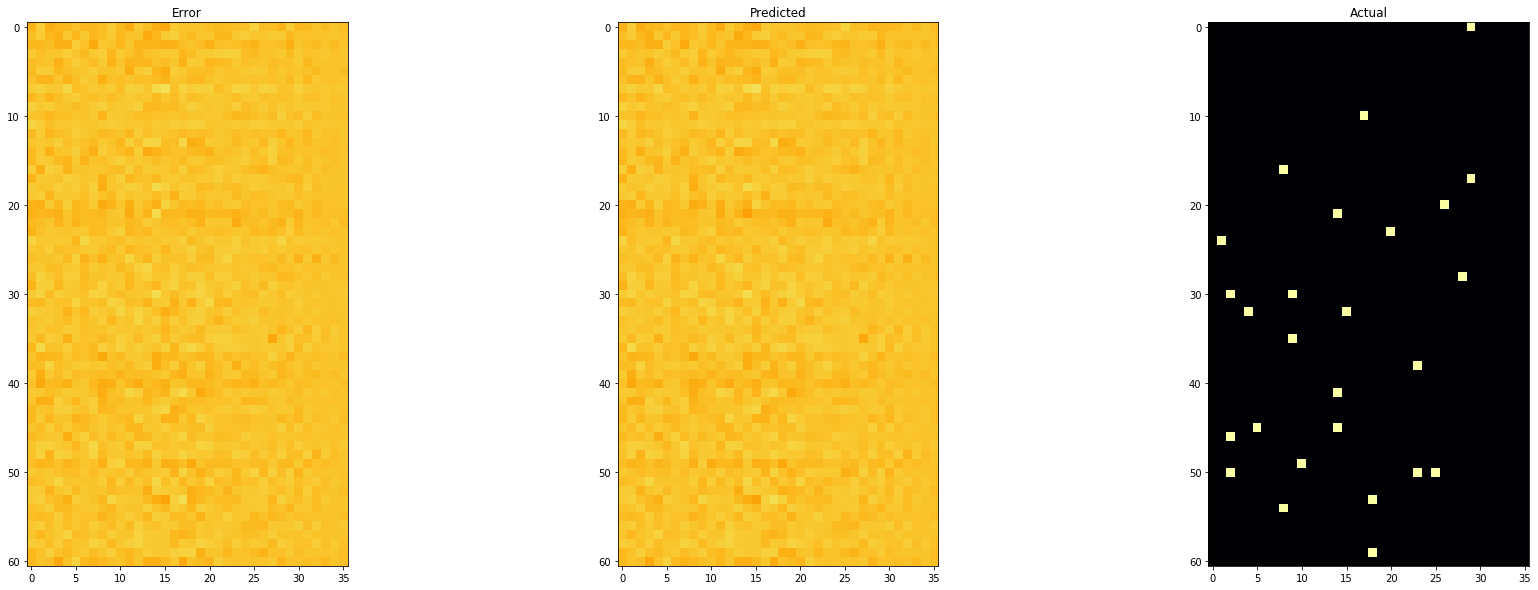

In [8]:
import plotting

input_pcms, notes_actual = generate_batch()

loss_value, notes_predicted, (new_grads, global_norm) = grad(network, input_pcms, notes_actual)
        
plt = plotting.error(notes_predicted, notes_actual)

del plt

In [ ]:
import gc

gc.collect()